In [1]:
import os
import pandas as pd
import re

In [2]:
RANDOM_SEED = 43

In [3]:
df = pd.read_csv("../../dataset/nlbse-2023-issue-report.csv")
df.shape
df = df[df['labels']=='bug']
print(df.shape)
df_unique = df.drop_duplicates(subset='id', keep='first')
print(df_unique.shape)
df = df_unique
df["id"] = df["id"].astype(int)
df_selected = df[['id','body']]

concatenated_df = pd.read_csv("../../dataset/Manual-labelled-data-25K.csv")
concatenated_df_selected = concatenated_df[['Issue_id','Candidate_String', 'is_secret_human_label']]

# Rename columns for consistency
df_selected = df_selected.rename(columns={'body': 'text'})
concatenated_df_selected = concatenated_df_selected.rename(columns={'Candidate_String': 'candidate_string', 'is_secret_human_label': 'label'})

# Merge the two DataFrames on a common key, for example, 'id'
# Adjust the merge key as needed based on your data
merged_df = concatenated_df_selected.merge(df_selected, left_on='Issue_id', right_on='id')
print(merged_df.shape)
columns_to_remove = ['id']
merged_df.drop(columns=columns_to_remove, inplace=True)
print(merged_df.columns)



C:\Users\ahmed\AppData\Local\Temp\ipykernel_1612\1832453507.py:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../dataset/nlbse-2023-issue-report.csv")


(745732, 6)
(726503, 6)
(25451, 5)
Index(['Issue_id', 'candidate_string', 'label', 'text'], dtype='object')


In [4]:
def preprocess(text):
        input_string =  text   
        input_string = re.sub(r'[\'"\│]', '', input_string)
        dir_list_clean = re.sub(r'drwx[-\s]*\d+\s+\w+\s+\w+\s+\d+\s+\w+\s+\d+\s+[0-9a-fA-F-]+.*','',input_string)
        shell_code_free_text = re.sub(r'```shell([^`]+)```','',dir_list_clean,flags=re.IGNORECASE)
        shell_code_free_text = re.sub(r'```Shell\s*"([^"]*)"\s*```','',shell_code_free_text,flags=re.IGNORECASE)
        # saved_game_free_text = re.sub(r'```([^`]+)```','',shell_code_free_text) #etay jhamela hobe
        saved_game_free_text = re.sub(r'<details><summary>Saved game</summary>\n\n```(.*?)```', '', shell_code_free_text)
        remove_packages = re.sub(r'(\w+\.)+\w+','',saved_game_free_text)
        java_exp_free_text = re.sub(r'at\s[\w.$]+\.([\w]+)\(([^:]+:\d+)\)','',remove_packages)
        # url_free_text= re.sub(https?://[^\s#]+#[A-Za-z0-9\-]+,'', java_exp_free_text, flags=re.IGNORECASE)
        url_with_fragment_text= re.sub(r'https?://[^\s#]+#[A-Za-z0-9\-\=\+]+','', java_exp_free_text, flags=re.IGNORECASE)
        url_free_text= re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '',url_with_fragment_text)
        commit_free_text= re.sub(r'commit[ ]?(?:id)?[ ]?[:]?[ ]?([0-9a-f]{40})\b', '', url_free_text, flags=re.IGNORECASE)
        file_path_free_text = re.sub(r"/[\w/. :-]+",'',commit_free_text)
        file_path_free_text = re.sub( r'(/[^/\s]+)+','',file_path_free_text)
        sha256_free_text = re.sub(r'sha256\s*[:]?[=]?\s*[a-fA-F0-9]{64}','',file_path_free_text)
        sha1_free_text = re.sub(r'git-tree-sha1\s*=\s*[a-fA-F0-9]+','',sha256_free_text)
        build_id_free_text = re.sub(r'build-id\s*[:]?[=]?\s*([a-fA-F0-9]+)','',sha1_free_text)
        guids_free_text = re.sub(r'GUIDs:\s+([0-9a-fA-F-]+\s+[0-9a-fA-F-]+\s+[0-9a-fA-F-]+)','',build_id_free_text)
        uuids_free_text = re.sub(r'([0-9a-fA-F-]+\s*,\s*[0-9a-fA-F-]+\s*,\s*[0-9a-fA-F-]+)','',guids_free_text)
        event_id_free_text = re.sub(r'<([^>]+)>','',uuids_free_text)
        UUID_free_text = re.sub(r'(?:UUID|GUID|version|id)[\\=:"\'\s]*\b[a-fA-F0-9]{8}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{4}-[a-fA-F0-9]{12}\b'
,'',event_id_free_text,flags=re.IGNORECASE) ##without the prefix so many false positives can be omitted
        hex_free_text = re.sub(r'(?:data|address|id)[\\=:"\'\s]*\b0x[0-9a-fA-F]+\b','',UUID_free_text,flags=re.IGNORECASE) ## deleting hex ids directly can cause issues
        ss_free_text = re.sub(r'Screenshot_(\d{4}[_-]\d{2}[_-]\d{2}[_-]\d{2}[_-]\d{2}[_-]\d{2}[_-]\d{2}[_-]\w+)','',hex_free_text,flags=re.IGNORECASE)
        cleaned_text = ss_free_text
        return cleaned_text
    

In [5]:
count=0
inverse_count=0
#print(preprocessed_df['modified_text'][2])
for i in range(merged_df.shape[0]):
  #print(i)
  main_string=merged_df['text'][i]
  substring=merged_df['candidate_string'][i]
  if substring in main_string:
    count+=1
  else:
    inverse_count+=1
    merged_df['text'][i] = preprocess(merged_df["text"][i])
print("Mismatch: "+str(inverse_count))
print("Ok: "+str(count))

C:\Users\ahmed\AppData\Local\Temp\ipykernel_1612\3443848363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['text'][i] = preprocess(merged_df["text"][i])
C:\Users\ahmed\AppData\Local\Temp\ipykernel_1612\3443848363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['text'][i] = preprocess(merged_df["text"][i])
C:\Users\ahmed\AppData\Local\Temp\ipykernel_1612\3443848363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

Mismatch: 1807
Ok: 23644


C:\Users\ahmed\AppData\Local\Temp\ipykernel_1612\3443848363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['text'][i] = preprocess(merged_df["text"][i])
C:\Users\ahmed\AppData\Local\Temp\ipykernel_1612\3443848363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['text'][i] = preprocess(merged_df["text"][i])
C:\Users\ahmed\AppData\Local\Temp\ipykernel_1612\3443848363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [6]:
#print(merged_df.size)
#print(merged_df.shape[0])
#print(type(merged_df))
#print(merged_df.head())
preprocessed_df=None
count=0
inverse_count=0
for i in range(merged_df.shape[0]):
  main_string=merged_df['text'][i]
  substring=merged_df['candidate_string'][i]
  if substring not in main_string:
    count+=1
  else:
    inverse_count+=1
    # Append the row to preprocessed_df
    if preprocessed_df is None:
      preprocessed_df = pd.DataFrame(merged_df.iloc[i, :]).transpose()
    else:
      preprocessed_df = pd.concat([preprocessed_df, pd.DataFrame(merged_df.iloc[i, :]).transpose()], ignore_index=True)

print("Mismatch: "+str(count))
print("Ok: "+str(inverse_count))
print(preprocessed_df.shape)
#print(preprocessed_df.head())


Mismatch: 423
Ok: 25028
(25028, 4)


## Context Window

In [7]:
def create_context_window(text, target_string, window_size=250):

    target_index = text.find(target_string)

    if target_index != -1:
        start_index = max(0, target_index - window_size)
        end_index = min(len(text), target_index + len(target_string) + window_size)
        context_window = text[start_index:end_index]
        return context_window

    return None

# Apply the create_context_window function to each row in the DataFrame
preprocessed_df['modified_text'] = preprocessed_df.apply(lambda row: create_context_window(row['text'], row['candidate_string']), axis=1)
#preprocessed_df['modified_text'] = preprocessed_df['text']
print(preprocessed_df.shape)
print(preprocessed_df['modified_text'].head())

(25028, 5)
0    H SSH CONNECTION FOR USER: ubuntu\r\n<ec2-serv...
1    \r\n**Screenshots**\r\n\r\n\r\n**Desktop/Devic...
2    eLight:serika,themeDark:serika_dark,autoSwitch...
3    ### What happened?\n\ngws-ingress services kee...
4    ckage:flutter_hooks/flutter_hooks.dart';\r\n\r...
Name: modified_text, dtype: object


In [8]:
count=0
inverse_count=0
#print(preprocessed_df['modified_text'][2])
for i in range(preprocessed_df.shape[0]):
  #print(i)
  main_string=preprocessed_df['modified_text'][i]
  substring=preprocessed_df['candidate_string'][i]
  if substring in main_string:
    count+=1
  else:
    inverse_count+=1
print("Mismatch: "+str(inverse_count))
print("Ok: "+str(count))

Mismatch: 0
Ok: 25028


In [9]:
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

c:\Users\ahmed\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##Setting Seeds

In [10]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## works fine

In [11]:
# Load and prepare your dataset
# You will have two lists: X_text (text bodies) and X_candidate (candidate strings)

# Encode text bodies and candidate strings separately
X_issue_ids = preprocessed_df['Issue_id'].tolist()
X_text = preprocessed_df['modified_text'].tolist()  # Convert the 'text' column to a list of strings
X_candidate = preprocessed_df['candidate_string'].tolist()  # Convert the 'candidate_string' column to a list of strings
Y_labels = preprocessed_df['label'].tolist()

In [12]:
# X_text = X_text[0:100]
# X_candidate = X_candidate[0:100]
# Y_labels = Y_labels[0:100]

In [13]:
def find_duplicates(mylist):
    newlist=[]
    duplist=[]
    for i in mylist:
      if i not in newlist:
          newlist.append(i)
      else:
          duplist.append(i)
    return newlist,duplist

In [14]:
# unique_issue_ids,dup_issue_ids=find_duplicates(X_issue_ids)
# print(len(X_issue_ids))
# print(len(unique_issue_ids))
# print(len(dup_issue_ids))
# for i in range(len(X_issue_ids)-len(dup_issue_ids)):
#   dup_issue_ids.append('0')

In [15]:
split_ratio = 0.2
X_text_train, X_text_test, X_candidate_train, X_candidate_test, Y_labels_train, Y_labels_test,X_issue_ids_train,X_issue_ids_test = train_test_split(
        X_text, X_candidate, Y_labels,X_issue_ids, test_size=split_ratio, random_state=RANDOM_SEED
)

In [16]:
# split_test_data = pd.DataFrame(list(zip(X_issue_ids_test,X_text_test, X_candidate_test, Y_labels_test)), columns=['Issue ID','Issue Body', 'Candidate String', 'Label'])
# split_train_data = pd.DataFrame(list(zip(X_issue_ids_train,X_text_train, X_candidate_train, Y_labels_train)), columns=['Issue ID','Issue Body', 'Candidate String', 'Label'])
# split_test_data.to_csv('../dataset/split_test.csv')
# split_train_data.to_csv('../dataset/split_train.csv')
# print(split_train_data.shape)
# print(split_test_data.shape)


In [17]:
type(Y_labels_test), len(Y_labels_test)

(list, 5006)

In [18]:
print(len(X_text_train), len(X_text_test))

20022 5006


In [19]:
!nvidia-smi

Wed May 29 20:48:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 53%   43C    P8             17W /  225W |     463MiB /   8192MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
# Tokenize text bodies and candidate strings separately
def encode_texts(texts):
    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    return encodings

tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")

In [21]:
text_body_encodings = encode_texts(X_text_train)
candidate_encodings = encode_texts(X_candidate_train)

In [22]:
# Define a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, text_encodings, candidate_encodings, labels):
        self.text_encodings = text_encodings
        self.candidate_encodings = candidate_encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx): #it works fine for training
        text_input_ids = self.text_encodings['input_ids'][idx]
        text_attention_mask = self.text_encodings['attention_mask'][idx]
        candidate_input_ids = self.candidate_encodings['input_ids'][idx]
        candidate_attention_mask = self.candidate_encodings['attention_mask'][idx]
        label = torch.tensor(self.labels[idx])

        return text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, label

# train_dataset = CustomDataset(text_body_encodings, candidate_encodings, Y_train)
# test_dataset = CustomDataset(X_test_text, X_test_candidate, Y_test)

In [23]:
np.unique(np.asarray(Y_labels_train), return_counts=True)

(array([0, 1], dtype=int64), array([19677,   345], dtype=int64))

In [24]:
print(type(Y_labels_train), len(Y_labels_train))
Y = np.array(Y_labels_train)
Y_ =Y.astype(int)

<class 'list'> 20022


In [25]:
train_dataset = CustomDataset(text_body_encodings, candidate_encodings, Y_)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
print(len(train_loader))

2503


In [27]:
type(np.array(Y_labels_train))


numpy.ndarray

In [28]:

torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

## Fine-tune Electra

In [29]:
model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [30]:
# Fine-tune Electra



#optimizer = AdamW(model.parameters(), lr=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


# learning_rate = 1e-5
# momentum = 0.9  # If using SGD with momentum
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


# learning_rate = 1e-5
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)



# learning_rate = 1e-5
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

num_epochs = 10

# Training loop
model.train()
for epoch in range(num_epochs):
    c = 1
    # for batch in train_loader:
    #     print("batch: ",c)
    #     text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, labels = batch
    #     text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, labels = text_input_ids.to(device), text_attention_mask.to(device), candidate_input_ids.to(device), candidate_attention_mask.to(device), labels.to(device)

    #     outputs = model(input_ids=text_input_ids, attention_mask=text_attention_mask, labels=labels)
    #     loss = outputs.loss
    #     loss.backward()
    #     optimizer.step()
    #     optimizer.zero_grad()
    for batch in train_loader:
        print("epoch: ",epoch)
        print("batch: ", c)
        text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, labels = batch

        # Ensure that you access the tensors with integer indices, not string keys
        text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, labels = (
            text_input_ids.to(device),
            text_attention_mask.to(device),
            candidate_input_ids.to(device),
            candidate_attention_mask.to(device),
            labels.to(device)
        )
        with torch.no_grad():
            for module in model.modules():
                if isinstance(module, torch.nn.Dropout):
                    module.p = 0  # Set dropout probability to 0

        # The rest of your training code
        outputs = model(input_ids=text_input_ids.type(torch.LongTensor).cuda(), attention_mask=text_attention_mask.type(torch.LongTensor).cuda(), labels=labels.type(torch.LongTensor).cuda())
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        c = c+1

# Evaluate the model
model.eval()
# with torch.no_grad():
#     for batch in test_loader:
#         text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, labels = batch
#         text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, labels = text_input_ids.to(device), text_attention_mask.to(device), candidate_input_ids.to(device), candidate_attention_mask.to(device), labels.to(device)

#         outputs = model(input_ids=text_input_ids, attention_mask=text_attention_mask)
#         predicted_labels = torch.argmax(outputs.logits, dim=1)



epoch:  0
batch:  1
epoch:  0
batch:  2
epoch:  0
batch:  3
epoch:  0
batch:  4
epoch:  0
batch:  5
epoch:  0
batch:  6
epoch:  0
batch:  7
epoch:  0
batch:  8
epoch:  0
batch:  9
epoch:  0
batch:  10
epoch:  0
batch:  11
epoch:  0
batch:  12
epoch:  0
batch:  13
epoch:  0
batch:  14
epoch:  0
batch:  15
epoch:  0
batch:  16
epoch:  0
batch:  17
epoch:  0
batch:  18
epoch:  0
batch:  19
epoch:  0
batch:  20
epoch:  0
batch:  21
epoch:  0
batch:  22
epoch:  0
batch:  23
epoch:  0
batch:  24
epoch:  0
batch:  25
epoch:  0
batch:  26
epoch:  0
batch:  27
epoch:  0
batch:  28
epoch:  0
batch:  29
epoch:  0
batch:  30
epoch:  0
batch:  31
epoch:  0
batch:  32
epoch:  0
batch:  33
epoch:  0
batch:  34
epoch:  0
batch:  35
epoch:  0
batch:  36
epoch:  0
batch:  37
epoch:  0
batch:  38
epoch:  0
batch:  39
epoch:  0
batch:  40
epoch:  0
batch:  41
epoch:  0
batch:  42
epoch:  0
batch:  43
epoch:  0
batch:  44
epoch:  0
batch:  45
epoch:  0
batch:  46
epoch:  0
batch:  47
epoch:  0
batch:  48
e

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

Model Load/Save

In [31]:
#Save the model to a file
model_path = "../../models/electra/electra_adamW_cntxt250_data25k_pre.pth"
torch.save(model.state_dict(), model_path)


In [32]:
# Load the model from the file
model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=2)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode for inference


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Test Dataset here

In [34]:
text_body_encodings_test = encode_texts(X_text_test)
candidate_encodings_test = encode_texts(X_candidate_test)

In [35]:
print(type(Y_labels_test), len(Y_labels_test))
Y_test = np.array(Y_labels_test)
print(type(Y_test), len(Y_test))
print(Y_test[:4085])
#for i in range(len(Y_test)):
#  if Y_test[i] ==  ' AWS4-HMAC-SHA256 Credential':
#    Y_test[i]='1'
Y_test_ =Y_test.astype(int)


<class 'list'> 5006
<class 'numpy.ndarray'> 5006
[0 0 0 ... 0 0 0]


In [36]:

test_dataset = CustomDataset(text_body_encodings_test, candidate_encodings_test, Y_test_)

In [37]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [38]:
model.to(device)
model.eval()  # Set the model in evaluation mode
c=0
predicted_labels_list = []
with torch.no_grad():

    for batch in test_loader:
        print("Batch %d"%c)
        c+=1

        text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, labels = batch

        # Move tensors to the device
        text_input_ids, text_attention_mask, candidate_input_ids, candidate_attention_mask, labels = (
            text_input_ids.to(device),
            text_attention_mask.to(device),
            candidate_input_ids.to(device),
            candidate_attention_mask.to(device),
            labels.to(device)
        )

        # Perform inference

        outputs = model(input_ids=text_input_ids.type(torch.LongTensor).cuda(), attention_mask=text_attention_mask.type(torch.LongTensor).cuda())
        predicted_labels = torch.argmax(outputs.logits, dim=1)

        # print(f"predicted_labels: {predicted_labels}")
        predicted_labels_list.append(predicted_labels[0])

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


In [39]:
predicted_labels_list_output = [f.cpu().numpy().tolist() for f in predicted_labels_list]

In [40]:
# print(len(X_candidate_test))
# print(len(Y_labels_test))
# print(len(predicted_labels_list_output))
# print(len(X_issue_ids_test))
# print(len(X_text_test))
# test_text=[]
# test_id=[]
# test_can=[]
# test_label=[]
# test_pred=[]
# for i in range(len(Y_labels_test)):
#   if Y_labels_test[i] == '1':
#     test_text.append((X_text_test[i].replace("\n", "")).replace("\r", ""))
#     test_id.append(X_issue_ids_test[i])
#     test_can.append(X_candidate_test[i])
#     test_label.append(Y_labels_test[i])
#     test_pred.append(predicted_labels_list_output[i])


# dict = {'Issue Id':test_id ,'Body':test_text,'Candidate String':test_can,'Actual Label': test_label, 'Predicted Label': test_pred}
# df = pd.DataFrame(dict)
# df.to_csv('positive_data.csv', sep=',', index=False)


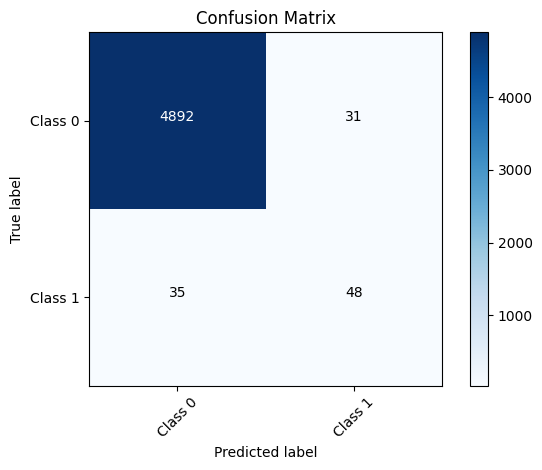

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y_labels_test, predicted_labels_list_output)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Class 0', 'Class 1']  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('Bert_AdamW_CW125_lr1e-5.png')
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [43]:
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    beta=2
    f1_beta = ((1+beta)*precision*recall)/(beta*precision+recall)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "f1": f1,
        "recall": recall,
        "f1_beta":f1_beta
    }

Check Metrics

In [44]:
metrics = get_metrics(Y_test_, predicted_labels_list_output)

In [45]:
metrics

{'accuracy': 0.9868158210147823,
 'precision': 0.6075949367088608,
 'f1': 0.5925925925925926,
 'recall': 0.5783132530120482,
 'f1_beta': 0.5877551020408164}

In [46]:
def get_minority_metrics(y_true, y_pred, minority_class_label):
    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the metrics for the minority class
    minority_indices = np.where(y_true == minority_class_label)
    y_true_minority = y_true[minority_indices]
    y_pred_minority = y_pred[minority_indices]

    # Calculate precision, recall, and F1-score for the minority class
    minority_precision = precision_score(y_true_minority, y_pred_minority)
    minority_recall = recall_score(y_true_minority, y_pred_minority)
    minority_f1 = f1_score(y_true_minority, y_pred_minority)

    beta=2
    minority_f1_beta = ((1+beta)*minority_precision*minority_recall)/(beta*minority_precision+minority_recall)

    return {
        'Minority Precision': minority_precision,
        'Minority Recall': minority_recall,
        'Minority F1-Score': minority_f1,
        "Minority f1_beta":minority_f1_beta
    }

In [47]:
minority_metrics = get_minority_metrics(Y_test_, predicted_labels_list_output, 1)

In [48]:
minority_metrics

{'Minority Precision': 1.0,
 'Minority Recall': 0.5783132530120482,
 'Minority F1-Score': 0.7328244274809159,
 'Minority f1_beta': 0.6728971962616821}